### Clusterless Decoding Implementation

We first simulate the movement of the mouse running back and fourth along a linear track with the following transition probability

$p(x_k | x_{k-1}) \sim N(\alpha x_{k-1}, \sigma)$

In [45]:
import numpy as np
import matplotlib.pyplot as plt

In [46]:
alpha = 0.98
sigma = 0.05
n_timesteps = 1000
x = np.zeros(n_timesteps)

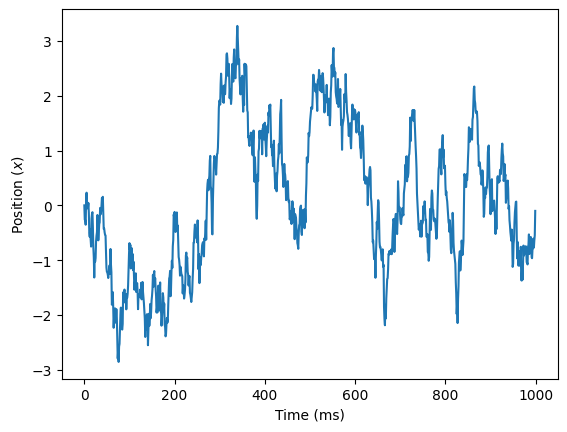

In [47]:
for k in range(n_timesteps - 1):
    x[k + 1] = np.random.normal(alpha * x[k], np.sqrt(sigma))


plt.figure()
plt.plot(x)
plt.xlabel('Time (ms)')
plt.ylabel('Position ($x$)')
plt.show()


We now define our simulation joint mark intensity $\lambda(t, \vec{m})$ of two hippocampal place cells using a bivariate Gaussian mixture function as in Eq. 8




In [48]:
def joint_mark_intensity(x, m, mu_x, mu_m, sigma_x, sigma_m, a):
    '''
    The joint mark intensity function for our simulation model.
    '''
    
    jmi = 0
    for c in [0,1]:
        jmi += np.exp( (a[c]- (x - mu_x[c])**2) / (2*sigma_x[c]**2)  -  ((m - mu_m[c])**2) / (2*sigma_m[c]**2))
        
    return jmi



We also integrate the joint mark intensity to get our ground process rate $ \Lambda(t) = \int_M \lambda(t, \vec{m})dm$ 

In [49]:
def ground_process_rate(x, mu_x, sigma_x, a):
    '''
    The ground process for our simulation model, which is the integral of the joint mark intensity function with respect to m.
    '''

    rate = 0
    for c in [0,1]:
        rate += np.exp(a[c]) * np.exp(-((x - mu_x[c])**2) / (2*sigma_x[c]**2))
    
    return rate
    


Finally, we can get that the marks associated with the spike trains which are sampled from the pdf $f(\vec{m}|t) = \frac{\lambda(t, \vec{m})}{\Lambda(t|H_t)}$

In [50]:
def marks_pdf(m, t, x, mu_x, mu_m, sigma_x, sigma_m, a):
    '''
    The marks pdf for our simulation model which is the joint mark intensity divided by the ground process rate.
    '''
    
    return joint_mark_intensity(x[t], m, mu_x, mu_m, sigma_x, sigma_m, a) / ground_process_rate(x[t], mu_x, mu_m, sigma_x, sigma_m, a)

First thing to do is simulate our ground process (spikes) by using the ground process rate $ \Lambda(t)$ with an inhomogenous Poisson process

In [51]:
# use the ground process rate to simulate an inhomogeneous Poisson process

def HomogeneousPoisson(rate, t_old):
    """
    Generate a new event time for a homogeneous Poisson process.
    """
    u = np.random.rand()
    t_new = -np.log(u) / rate + t_old
    return t_new

def InHomoPoisson(rate, t_old):
    """
    Simulate an inhomogeneous Poisson process using the thinning algorithm.
    """
    gmax = np.max(rate)  # Upper bound for thinning

    while True:
        # Generate a candidate event time from the homogeneous Poisson process
        t = HomogeneousPoisson(gmax, t_old)

        # Check if time exceeds rate length (end of simulation)
        if t >= len(rate):
            return None  # Signal end of process

        # Interpolate the rate at the candidate time
        rate_value = np.interp(t, np.arange(len(rate)), rate)

        # Thinning: Accept or reject the event
        u = np.random.rand()
        if u * gmax < rate_value:
            return t  # Event accepted
        else:
            t_old = t  # Update the last time and continue
            


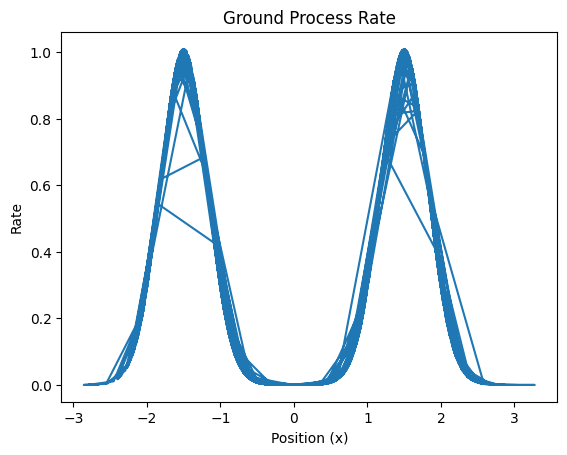

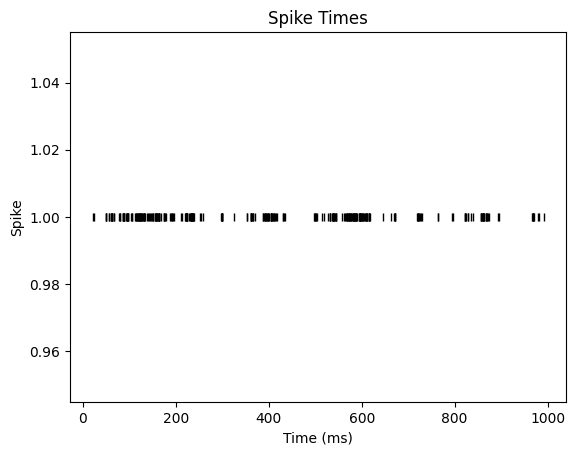

In [54]:

mu_x = [-1.5, 1.5]
sigma_x = [np.sqrt(0.1), np.sqrt(0.1)]
a = [0.01, 0.01]
mu_m = [10, 13]
sigma_m = [1, 1]

# simulating the underlying unmarked spike trains under an inhomogenous Poisson process model wirh rate given by the integral of the jmi over the marks
m = np.zeros(n_timesteps)
rate = np.zeros(n_timesteps)

for k in range(n_timesteps):
    rate[k] = ground_process_rate(x[k], mu_x, sigma_x, a)


plt.figure()
plt.plot(x, rate)
plt.xlabel("Position (x)")
plt.ylabel("Rate")
plt.title("Ground Process Rate")
plt.show()



# simulating the spike times using the inhomogeneous Poisson process
spike_times = []
t = 0
while t < n_timesteps:
    t = InHomoPoisson(rate, t)
    if t is not None:
        spike_times.append(t)
    else:
        break


# plotting the spike times
plt.figure()
plt.plot(spike_times, np.ones(len(spike_times)), 'k|')
plt.xlabel('Time (ms)')
plt.ylabel('Spike')
plt.title('Spike Times')
plt.show()







    

 

    